<a href="https://colab.research.google.com/github/markriedl/POP/blob/main/planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Note: this notebook does not require a GPU and can be downloaded and run in jupyter lab.**

Partial order planning searches the space of possible plans, looking for one that contains a partially-ordered sequence of actions that transforms an initial state to a state in which a goal situation holds.

The initial state is a list of clauses. A clause is a logical predicate of the form `(predicate_name, parameter1, parameter2, ..., parameterN)`. For example, if we wish to express that "John is at the store", then we would write `("at", "john", "store")`. Symbols are strings that are reused and have meaning to the user. The initial state is a list of clauses. Anything that is listed is true in the initial state of the world. Anything that is not in the list can be assumed to be false.

A goal is a set of clauses that we want to be true by the end of the plan. Other clauses can be true, but those listed must be true. Clauses in the goal can be of the form given above, but can also include negated clauses `(NOT, (predicate_name, parameter1, parameter2, ... parameterN))`. For example if we what John to not be at the store, then `(NOT, ("at", "john", "store))`.

Operators are the means by which the state of the world can be changed. Operators are schemas that have N pieces of information:
 - **name:** the name of the operator (e.g., "move")
 - **vars:** the parameters of the operator (e.g., person, start, destination)
 - **constraints:** a set of clauses that must be true in the initial state and never change. Constraints are typically clauses about types and imutable properties. For example if want to put constraints on the variables above, we might have e.g., `("person", person), ("location", start), ("location, destination)`. Constraints can also be of the form `(NEQ, var1, var2)` indicating that two variables cannot be bound to the same value. 
 - **pre:** the precondition, the set of clauses that must be true for the operator to be used.
 - **effect:** the set of clauses that will be true after an operator finishes executing.

The planner will figure out which operators to put into the plan. When an operator is instantiated and put into the plan, we refer to it as an "action" and the variables in vars, pre, and effect, become "bound". A variable is bound when a symbol is assigned to the variable. The plan's "bindings" is a dictionary that maps variables to symbols (strings). Actions are instantiated because a goal clause is not satisfied. That is, there is nothing in the plan that makes the clause true. When an action is instantiated into the plan to make a goal clause true, we record that relationship with a *causal link*. A causal link is of the form:
```
LINK:
  source: action_id
  target: action_id
  clause: clause of the target being satisfied by an effect of source
```
Actions are also instantiated if any other action has a clause in its precondition that is not satisfied.

To make things easier, we convert the initial state into a dummy action (`:init`) in which the action's effect is the list of initial state clauses.
We also use a goal dummy action (`:goal`) in which the precondition is the list of goal clauses. The init dummy action creates the initial state with its effects and thus must always be first. The goal dummy action requires all goal clauses and must always be last.

Plans also have ordering constraints. Ordering constraints are doubles `(action_id1, action_id2)` indicating that action 1 must be absolutely ordered before action 2.

Plans have *flaws*. Flaws are reasons why the plan is not complete. In standard planning, there are two types of flaws:
 - **Open flaw:** A goal clause or a precondition of an action is unsatisfied. That is, there is no causal link that links that precondition of that action to the effect of an earlier action (or initial state). Open flaws are resolved by adding a new action, finding an existing action with an effect that satisfies the open clause, or linking to the initial state. In reality, all legal options are tried.
 - **Causal threat:** There is an action with an effect that negates the clause of a causal link and no ordering constraints that prohibit that action from occuring during the causal link. Think of a causal link as a duration in which the clause must remain true. Causal threats are resolved by ordering the threatening action before the duration of the causal link or after. Both are tried.

A plan object thus has the following members:
 - **id:** Each plan has a unique identifier
 - **actions:** Set of actions (unordered), including the init dummy action and goal dummy action.
 - **binds:** The variable bindings, a dictionary.
 - **ordering:** Set of ordering constraints. The ordering constraints partially orders the set of actions.
 - **links:** Set of causal links.
 - **flaws:** Set of flaw objects.
 - **reason:** A data structure that stores information about the reason the plan was created (what flaw was being resolved).
 - **parent:** A pointer to the parent plan. 

For debugging help, every plan that gets created is added to a global `ALL_PLANS`. Look at the reason and parents to get a sense of what plans were created and why.

# Installation

The unification package helps with binding variables to values

In [1]:
!pip install unification

PyDot is for rendering graphs

In [ ]:
!pip install pydot

Import packages

In [2]:
from unification import *
import struct
import copy
import pdb
from enum import Enum
import pydot
from IPython.display import Image

# Classes, Types, Enums

`gensym` creates a unique symbol name (as a string)

In [3]:
### Global counter variable
COUNTER = 0

### Default separator
SEP = 'v'

def gensym(s = None):
  global COUNTER
  sym = COUNTER
  if s is not None:
    sym = s + str(sym)
  COUNTER = COUNTER + 1
  return sym

  ### TODO: create a set of counters for different things (plans, actions, etc.). 
  ### Create COUNTERS = {} and use the s as the key

Globals

In [4]:
NOT = ":not"   # This is used to indicate negation
NEQ = ":neq"   # This is "not equals"

# Partial order planners operate on flaws. There are currently two types of flaws
# Open flaws indicate that an action has a precondition that is not satisfied by an earlier action
# Causal threats indicate that there is an action that could occur during an interval where it would undo a causal link
class FLAW(Enum):
  OPEN = "open"       # Open flaw
  THREAT = "threat"   # Causal threat flaw

Object types

In [5]:
### PLAN CLASS
### 
### Stores information for the planning problem (initial state and goals) and the current state of solving the problems

class Plan():
  def __init__(self, init, goal):
    ## Start by creating the dummy init and goal actions
    ## The init action has no precondition and the effects establish the initial state
    ## The goal action has no effect and the precondition is the goal clauses
    self.actions = [Action(name = 'init', effect = init, id = ":init"), 
                    Action(name = 'goal', pre = goal, id = ":goal")]
    self.binds = {}                         # Bindings (dict)
    self.ordering = [(':init', ':goal')]    # Ordering list of (start, end)
    self.links = []                         # Causal links (list of Link objects)
    self.flaws = []                         # Flaw list (list of Flaw objects)
    self.id = gensym()                      # ID (String or number)
    self.reason = []                        # Misc information
    self.parent = None                      # Pointer to parent plan
    # Automatically set up the open list
    for clause in goal: 
      self.flaws.append(Flaw(flaw_type=FLAW.OPEN, data=(clause, ':goal'), source=None))

  ### Plan.print()
  def print(self):
    print(self.id)
    print('ACTIONS')
    for a in self.actions:
      a.print(self.binds)
    print('BINDS')
    print(self.binds)
    print('ORDERING')
    for o in self.ordering:
      print(o)
    print('LINKS')
    for l in self.links:
      l.print(self.binds)
    print('OPEN')
    for f in self.flaws:
      print(f)
    print("REASON")
    print(self.reason)

  ### Print human-readable version
  def pretty_print(self):
    # Get topological sort of actions
    top_sort = topological_sort(self.actions, self.ordering)
    # Remove init and goal actions
    top_sort = list(filter(lambda a: a in self.get_real_actions(), top_sort))
    # Print each action that remains
    for a in top_sort:
      print(a.id, a.name, apply_bindings_to_var_list(self.binds, a.vars))

  ### Get the :init action
  def get_init_action(self):
    for act in self.actions:
      if act.id == ':init':
        return act

  ### Get all actions that are not :init or :goal
  def get_real_actions(self):
    return list(filter(lambda a:a.id != ':init' and a.id != ':goal', self.actions))


#######################


### ACTION CLASS
### 
### The action class stores information for a particular type of action

class Action():
  def __init__(self, name, vars = [], pre = [], effect = [], constraints = [], id = gensym()):
    self.precondition = pre           # Precondition (list of clauses)
    self.effect = effect              # Effect (list of clauses)
    self.constraints = constraints    # Constraints (list of clauses, only checked against the init state)
    self.name = name                  # Name (string)
    self.id = id                      # ID (string or number)
    self.vars = vars                  # List of variables

  ### Action.print()
  def print(self, binds = {}):
    print('ACTION', self.id, self.name, apply_bindings_to_var_list(binds, self.vars))
    print('constraints', apply_bindings_to_clause_list(binds, self.constraints))
    print('pre', apply_bindings_to_clause_list(binds, self.precondition))
    print('effect', apply_bindings_to_clause_list(binds, self.effect))



###################################

### LINK CLASS
###
### A Causal link, which indicates when an effect of one action satsifies a precondition of another, later, action
### This is a labeled arc in a graph

class Link():
  def __init__(self, source, clause, target):
    self.source = source  # id of source action
    self.clause = clause  # clause of the causal link
    self.target = target  # id of target action

  ### Link.print()
  def print(self, binds = {}):
    print(self.source, apply_bindings_to_clause(binds, self.clause), self.target)

###########################

### FLAW CLASS
###
### Indicates when there is a flaw in a plan
### Indicates which plan the flaw was found in (can be inherited by children plans)
### Contains data about the flaw, though this differs based on the type of flaw

class Flaw():
  def __init__(self, flaw_type, data, source=None):
    self.flaw_type = flaw_type # Enum FLAW(OPEN or THREAT)
    self.data = data           # Information about the flaw
    self.source = source       # ID of the plan in which the flaw was initially found

  ### Flaw.print()
  def print(self, binds = {}):
    if self.flaw_type == FLAW.THREAT:
      link1 = self.data[0]
      link2 = self.data[1]
      link1.print(binds)
      link2.print(binds)
    elif self.flaw_type == FLAW.OPEN:
      print(apply_bindings_to_clause(binds, self.data[0]), self.data[1])


# Miscellaneous Helper functions

Create a total ordering for a partially ordered set of actions

In [6]:
def topological_sort(actions, ordering):
  sorted_actions = [] # final ordered list of actions
  # Get all actions that are preceded by another action (ids)
  seconds = list(set(map(lambda o:o[1], ordering)))
  # Get all actions that are not preceded by another action
  queue = list(set(filter(lambda a:a.id not in seconds, actions)))
  # Loop until all actions are used
  while len(queue) > 0:
    act = queue[0]     # current action
    # Pop act from list
    queue = queue[1:]
    # add current act to final list
    sorted_actions.append(act)
    # Update the list of actions that are preceded by another action that hasn't already been used (ids)
    seconds = list(set(map(lambda o: o[1], 
                       filter(lambda o: o[0] not in map(lambda a: a.id, 
                                                        sorted_actions), 
                              ordering))))
    # add all actions that are not preceded to the queue
    queue = queue + list(set(filter(lambda a:a.id not in seconds and a.id not in map(lambda a: a.id, sorted_actions) and a.id not in map(lambda a: a.id, queue), 
                                    actions)))
  # Return final sort
  return sorted_actions


Detect cycles in the orderings of actions

In [7]:
### It appears that topological sort always fails if there is a cycle. If this 
### ceases to hold, then use the commented out code instead.
def has_cycle(ordering, actions):
  ### Action indexes in topological order
  top_actions = list(map(lambda a: a.id, topological_sort(actions, ordering)))
  ### Topological sort can return prematurely if there is a cycle, so this is the first indication
  if len(top_actions) < len(actions):
    return True
  '''
  actions = top_actions
  print("top", actions)
  ancestors = {} # dict of ancestors of each action
  # Walk through plan in topological order
  for act in actions:
    print('ACT', act)
    # Prep the dict
    if act not in ancestors:
      ancestors[act] = []
    print(' ancestors', ancestors[act])
    # Get successors
    nexts = list(set(map(lambda o: o[1], filter(lambda o: o[0] == act, ordering))))
    # Look at each succesor 
    for n in nexts:
      print('next', n)
      # If the successors is also an ancestor, then we found a cycle
      if n in ancestors[act]:
        return True
      # Prep the dict
      if n not in ancestors:
        ancestors[n] = []
      # add the current act to the successor's ancestors plus any ancestors of the current act
      ancestors[n] = list(set(ancestors[n] + [act] + ancestors[act]))
      print(' ancestors', ancestors[n])
  '''
  return False

Getting and removing flaws, determing if a plan satisfies the goal, inserting a plan into a sorted list of plans

In [8]:
###################################

### Get the next open condition to work on
### Hard-coded to prefer solving causal threats (fail early is better)

def get_flaw(plan):
  for flaw in plan.flaws:
    if flaw.flaw_type == FLAW.THREAT:
      return flaw
  return plan.flaws[0]
    

##################################

### Remove a flaw from the plan. 
### The plan is destructively altered but the plan is returned because I am a lisp programmer

def remove_flaw(flaw, plan):
  for n, f in enumerate(plan.flaws):
    if f.flaw_type == flaw.flaw_type and f.data == flaw.data:
      plan.flaws = plan.flaws[:n] + plan.flaws[n+1:]
      return plan
  return plan
  
###################################

### Is this plan a goal (no open conditions)?

def is_goal(plan):
  return len(plan.flaws) == 0



###################################

### Insertion sort. Very inefficient if heuristic or cost are non-trivial
### TODO: store g and h in the plan object itself

def insert_plan(plan, queue):
  g = cost(plan)
  h = heuristic(plan)
  f = g + h
  for n, p in enumerate(queue):
    if f < cost(p) + heuristic(p):
      return queue[:n] + [plan] + queue[n:]
  return queue + [plan]


Turn clauses and actions into pretty readable strings

In [ ]:
def canonical_clause_str(clause, binds):
  ## Apply bindings to clause
  clause = apply_bindings_to_clause(binds, clause)
  neg = False # Is this clause a negation?
  if clause[0] == NOT:
    ## negation detected, process the inside of the negation
    neg = True
    clause = clause[1]
  ## write the string
  out = clause[0] + '('
  for n, x in enumerate(clause[1:]):
    if n == 0:
      out = out + x
    else:
      out = out + ',' + x
  out = out + ')'
  ## Put negation info back in
  if neg:
    out = NOT + '(' + out + ')'
  return out 

def canonical_action_str(act, binds):
  out = act.name + '('
  for n, x in enumerate(apply_bindings_to_var_list(binds, act.vars)):
    if n == 0:
      out = out + x
    else:
      out = out + ',' + x
  out = out + ')'
  return out 

Visualize plans as graphs

In [ ]:
def visualize(plan):
  graph = pydot.Dot('plan', graph_type='digraph')
  for action in plan.actions:
    graph.add_node(pydot.Node(str(action.id), shape='box', label=canonical_action_str(action, plan.binds)))
  for link in plan.links:
    graph.add_edge(pydot.Edge(str(link.source), str(link.target), color='blue', label=canonical_clause_str(link.clause, plan.binds)))
  for o in plan.ordering:
    graph.add_edge(pydot.Edge(str(o[0]), str(o[1]), style='dotted'))
  graph.write_png('output.png')
  return Image('output.png')

Default heuristic and cost functions

In [9]:
### HEURISTIC
### Number of open flaws as estimate of how much work remains

def heuristic(plan):
  return len(plan.flaws)

### COST
### Number of actions

def cost(plan):
  return len(plan.get_real_actions())


# Variable Binding

Variables, as found in action preconditions and effects, reference symbols in the world. A variable is "bound" when it has a symbol value associated with it and "unbound" if there is none. Bindings are kept as a dictionary where the variable is the key and the symbol is the value. A variable is a special type of object defined in the `unification` package, and symbols are strings that are reused and understood to have meaning to the user.

`unify_preconditions` takes two lists of clauses and determines if there are any variable bindings such that all the clauses in the post list are supported by all the clauses in the pre list. It doesn't just have to be applied to preconditions. In fact, preconditions are rarely unified all at once (instead they are broken up in to many different open condition flaws). This is used for constraints, which are like preconditions but are all unified at once and only against the initial state.

In [10]:
def unify_preconditions(pre, post, binds = {}):
  ### Make a list of possible worlds, each with an unique binding
  binds = [binds]
  ### Iterate through precondition clauses
  for p in pre:
    neg = False # Is this a negated clause? (:not (x, y, z))
    if p[0] == NOT:
      # If so, remember that and also only operate on the nested clause
      neg = True
      p = p[1]
    if p[0] != NEQ:
      # Don't process neqs
      # Make a temporary set of new worlds to collect up worlds that are still valid with new stuff
      new_binds = []
      # Iterate through each possible world
      for cur_binds in binds:
        # Make a deep copy of the bindings
        cur_binds = copy.deepcopy(cur_binds)
        if not neg:
          # If not negated, make new possible worlds for every unification with everything in the postcondition
          for i in post:
            b = unify(p, i, cur_binds)
            if b:
              # We unified, remember this new possible world
              new_binds.append(b)
        else:
          # We are dealing with a negated clause, look for cases where there are no unifications
          match = False # Have I unified?
          for i in post:
            b = unify(p, i, cur_binds)
            if b:
              # We unified, don't remember this possible world
              match = True
              break
          if not match:
            # We didn't unify with anything, this means this possible world is still good
            new_binds.append(cur_binds)
        # Move any possible worlds that survived to the next iteration
        binds = new_binds
  ### Apply neqs
  neqs = list(filter(lambda p:p[0] == NEQ, pre))
  new_binds = []
  # Iterate through possible worlds
  for cur_binds in binds:
    prune = False
    # Iterate through neqs
    for cur_neq in neqs:
      elt1 = cur_neq[1]
      elt2 = cur_neq[2]
      if cur_binds[elt1] == cur_binds[elt2] or cur_binds[elt2] == cur_binds[elt1]:
        # We have an equality, prune this possible world
        prune = True
        break
    if (not prune):
      # If we got this far then the possible world is still good
      new_binds.append(cur_binds)
  binds = new_binds
  return binds

Apply bindings in various ways. Applying a binding to a clause replaces any variables with the values.

In [11]:
### Apply bindings to a single clause

def apply_bindings_to_clause(binds, clause):
  new_clause = [] # Make a new clause
  is_neg = False # was the clause negated
  # Remember if the clause is negated
  if clause[0] == NOT:
    is_neg = True
    clause = clause[1]
  # Iterate through every element in the clause
  for elt in clause:
    if isinstance(elt, Var) and elt in binds:
      # This is a variable with a binding
      new_clause.append(binds[elt])
    else:
      # This is not a variable or not a variable with a binding
      new_clause.append(elt)
  # Convert list into a tuple
  new_clause = tuple(new_clause)
  # restore negation if necessary
  if is_neg:
    return (NOT, new_clause)
  else:
    return new_clause

##################################

### Apply bindings to a list of clauses

def apply_bindings_to_clause_list(binds, clause_list):
  new_list = []
  for clause in clause_list:
    new_list.append(apply_bindings_to_clause(binds, clause))
  return new_list

###################################

### Apply bindings to a list of variables (for example: action.vars)

def apply_bindings_to_var_list(binds, var_list):
  return_list = []
  # Iterate through variables
  for v in var_list:
    if v in binds:
      # This variable has a binding, substitute
      return_list.append(binds[v])
    else:
      # This variable does not have a binding
      return_list.append(v)
  return tuple(return_list)
  

# Instantiating operators

Getting operators that satisfy a needed claue (typically a clause in a precondition). This might be a new action, an existing action, or the initial state

In [12]:
### Given a clause that needs to be solved, find all the operators that might satisfy the need
### Returns an environment, a tuple containing (op, bindings)

def get_satisfying_ops(clause, binds, ops, init_state):
  new_envs = [] # Collect up new environments
  # Look at every available operator
  for op in ops:
    # check constraints first
    new_binds = unify_preconditions(op.constraints, init_state, binds)  
    # New_binds will be non-empty if constraints can be satisfied--keeps every way of satisfying them
    for new_bind in new_binds:        
      # iterate through the operator effects, look for one that unifies with the needed clause
      for eff in op.effect:
        b = unify(clause, eff, new_bind)
        if isinstance(b, dict):
          # This effect unifies, we found it
          new_envs.append((op, b))
          break
  # Return everything we found
  return new_envs






Instantiate an operator. An operator is an abstract action template. This makes it a real action ready to be put into a plan.

In [13]:
### Turn an operator (which is abstract) into an action (which is grounded with bound variables)

def instantiate_operator(op):
  # Copy the operator
  action = copy.deepcopy(op)
  # Give it a new ID
  action.id = gensym()
  # Make new vars
  new_vars = []
  # For every variable, make a new variable with the ID concatenated to it
  for v in action.vars:
    new_vars.append(var(v.token + SEP + str(action.id)))
  action.vars = new_vars
  # Make new precondition
  new_pre = []    
  # For every precondition clause, replace old variables with new variables
  for clause in action.precondition:
    new_clause = [] # Make a new clause
    is_neg = False # Keep track of whether the clause is negated
    if clause[0] == NOT:
      clause = clause[1]
      is_neg = True
    # Check if each element needs to be replaced by a new variable
    for elt in clause:
      if isinstance(elt, Var):
        new_clause.append(var(elt.token + SEP + str(action.id)))
      else:
        new_clause.append(elt)
    # Convert back into a tuple
    new_clause = tuple(new_clause)
    # Negate if needed
    if is_neg:
      new_clause = (NOT, new_clause)
    new_pre.append(new_clause)
  action.precondition = new_pre
  # Make new effect
  new_effect = [] 
  # For every effect clause, replace old variables with new variables
  for clause in action.effect:
    new_clause = [] # Make a new clause
    is_neg = False # keep track of whether the clause is negated
    if clause[0] == NOT:
      clause = clause[1]
      is_neg = True
    # check if each element needs to be replaced by a new variable
    for elt in clause:
      if isinstance(elt, Var):
        new_clause.append(var(elt.token + SEP + str(action.id)))
      else:
        new_clause.append(elt)
    # Convert back to tuple
    new_clause = tuple(new_clause)
    # Negate if needed
    if is_neg:
      new_clause = (NOT, new_clause)
    new_effect.append(new_clause)
  action.effect = new_effect
  return action


# Handling Causal Threats

A causal threat occurs when there is an action A in a plan that has an effect `¬ p` that undoes the effect of another action B `p` that is a causal necessity of a third action C that requires `p` as a precondition. 

Because the action in a plan are partially-ordered, there are two primary ways of resolving the causal threat. The first is to place action A before B so that there is no undoing of B's effects (promotion). The second is to place A after C (demotion). If neither work, then the planner may already have another way of achieving C's precondition in another branch of the search space.

Detect causal threats in a plan. A causal threat occurs when there are two overlapping periods of time whe P and ~P might both need to be true. This is because of partial ordering. To resolve the planner must decide to separate the region of time in which P is true from the region of time in which ~P is true.

In [14]:
### Return s list of causal threat flaws for a plan (if any)

def causal_threats(plan):
  actions = plan.actions
  links = plan.links
  ordering = plan.ordering
  binds = plan.binds
  act_hash = {} # for fast retrieval
  for a in actions:
    act_hash[a.id] = a
  actions = list(map(lambda a: a.id, actions)) # ids of actions
  used_actions = [] # actions that have been visited
  # Get all actions that are not preceded by another action
  queue = list(set(filter(lambda n: n not in map(lambda o: o[1], ordering), 
                    map(lambda o: o[0], ordering))))
  active_links_set = set() # all active links
  #active_conditions = [] # any conditions known to be true
  # Iterate through queue
  while len(queue) > 0:
    act = queue[0] # current action (id)
    action = act_hash[act] # full object
    # current action becomes visited
    used_actions.append(act) 
    # remove current action from queue
    queue = queue[1:]
    # find any links that have become inactive
    inactive_links_set = set(filter(lambda l: l.target == act, links))
    # find any links that have become active
    active_links_set = active_links_set.union(set(filter(lambda l: l.source == act, links))).difference(inactive_links_set)
    # Maintain active conditions. Active conditions are the effects of actions that may or may not be used as outgoing causal links.
    for link in active_links_set:
      for eff in action.effect:
        eff = apply_bindings_to_clause(binds, eff)
        clause = apply_bindings_to_clause(binds, link.clause)
        if eff == (NOT, clause) or clause == (NOT, eff):
          return Flaw(flaw_type = FLAW.THREAT, 
                      source = plan.id,
                      data=((link.source, link.clause, link.target),
                            (act, eff, ':goal')))  
    '''
    remove_list = []
    for n, cond in enumerate(active_conditions):
      for eff in act_hash[act].effect:
        if (eff[0] == NOT and cond[0] != NOT and apply_bindings_to_clause(binds, eff[1]) == apply_bindings_to_clause(binds, cond)) or (eff[0] != NOT and cond[0] == NOT  and apply_bindings_to_clause(binds, eff) == apply_bindings_to_clause(binds, cond[1])):
          remove_list.append(n)
    for n in remove_list[::-1]:
      active_conditions = active_conditions[:n] + active_conditions[n+1:]
    active_conditions = active_conditions + apply_bindings_to_clause_list(binds, act_hash[act].effect)
    '''
    # Check links against links. I'm not entirely sure this is necessary given the above
    for link1 in active_links_set:
      for link2 in active_links_set:
        clause1 = apply_bindings_to_clause(binds, link1.clause)
        clause2 = apply_bindings_to_clause(binds, link2.clause)
        if clause1 == (NOT, clause2) or clause2 == (NOT, clause1):
          return Flaw(flaw_type=FLAW.THREAT, 
                      source = plan.id,
                      data=((link1.source, link1.clause, link1.target),
                            (link2.source, link2.clause, link2.target))) 
    '''
    for link in active_links_set:
      for cond in active_conditions:
        link_cond = apply_bindings_to_clause(binds, link.clause)
        if cond == (NOT, link_cond) or link_cond == (NOT, cond):
          return Flaw(flaw_type = FLAW.THREAT, 
                      data=((link.source, link.clause, link.target),
                            (act, cond, ':goal')))  
    ''' 
    # successors
    seconds = list(set(map(lambda o: o[1], 
                           filter(lambda o: o[0] not in used_actions, 
                                   ordering))))
    # add all actions that are not preceded to the queue
    new_actions = list(set(filter(lambda a: a not in seconds and a not in used_actions and a not in queue, 
                                    actions)))
    queue = queue + new_actions
  return None

# Making new plans and fixing flaws

Open condition flaws are solved by making a new plan (cloning the old plan and updating it) that either adds a new action or reuses an existing action.

In [158]:
def make_new_plan_from_existing_action(plan, open_flaw, action, binds = {}):
  open_clause = open_flaw.data[0]
  open_source = open_flaw.data[1]
  # Make the new plan
  new_plan = copy.deepcopy(plan)
  new_plan.id = gensym()
  # Add new bindings
  if len(binds.keys()) > 0:
    new_binds = binds
  else:
    new_binds = plan.binds
  for clause in action.effect:
    b = unify(clause, open_clause, new_binds)
    if b:
      new_binds = b
  new_plan.binds = new_binds
  # Remove the open condition being worked on
  #new_plan.flaws.remove(open_flaw)
  new_plan = remove_flaw(open_flaw, new_plan)
  # Add new orderings
  new_plan.ordering.append((action.id, open_source))
  new_plan.ordering = list(set(new_plan.ordering))
  # Add new causal link
  new_plan.links.append(Link(action.id, open_clause, open_source))
  new_plan.reason.insert(0, ('new_from_existing', 'using', (action.id, action.name), "to solve", open_clause, "from", open_source))
  new_plan.parent = plan
  return new_plan

#####################################

def make_new_plan_from_new_op(plan, open_flaw, op, binds = {}):
  open_clause = open_flaw.data[0]
  open_source = open_flaw.data[1]
  # Make a new action with new, unique variables
  new_action = instantiate_operator(op)
  # Make the new plan
  new_plan = copy.deepcopy(plan)
  new_plan.id = gensym()
  # Add new bindings
  if len(binds.keys()) > 0:
    new_binds = binds
  else:
    new_binds = new_plan.binds
  for clause in new_action.effect:
    b = unify(clause, open_clause, new_binds)
    if b:
      new_binds = b
  new_plan.binds = new_binds
  # Remove the open condition being worked on
  #new_plan.flaws.remove(open_flaw)
  new_plan = remove_flaw(open_flaw, new_plan)
  # Add the new action
  new_plan.actions.append(new_action)
  # Add new orderings
  new_plan.ordering.append((new_action.id, open_source))
  new_plan.ordering.append((':init', new_action.id))
  new_plan.ordering = list(set(new_plan.ordering))
  # Add new causal link
  new_plan.links.append(Link(new_action.id, open_clause, open_source))
  # Make new open conditions
  for clause in new_action.precondition:
    new_plan.flaws.append(Flaw(flaw_type=FLAW.OPEN, source=plan.id, data=(clause, new_action.id)))
  new_plan.reason.insert(0, ('new_from_new_op', "making", (new_action.id, new_action.name), "to solve", open_clause, "from", open_source))
  new_plan.parent = plan
  return new_plan

Routine for fixing an open condition flaw: Open conditions can be solved by:
 - Extending a causal link from an existing action
 - Creating a new action and extending a causal link
 - (If condition is negated) extending a causal link from the initial state if the condition is not stated (under the closed world assumption)

In [161]:
def fix_open_flaw(plan, flaw, ops, init):
  open_flaw = flaw
  open_clause = open_flaw.data[0]
  open_source = open_flaw.data[1]
  new_plans = []
  # are any of the actions in the plan capable of satisfying the open condition?
  satisfying_envs = [] # env is (op, binds)
  #if open_clause[0] != NOT:
  satisfying_envs = get_satisfying_ops(open_clause, plan.binds, plan.get_real_actions() + [plan.get_init_action()], init) 
  print("satisfying ops", list(map(lambda e: (e[0].name, apply_bindings_to_var_list(e[1], e[0].vars)), satisfying_envs)))       
  # is the clause negated and satisfied by the initial state?
  #else:
  if open_clause[0] == NOT:
    init_act =  plan.get_init_action()
    if not get_satisfying_ops(open_clause[1], plan.binds, [init_act], init):
      satisfying_envs.append((init_act, plan.binds))
  # Make new plans from existing actions
  for env in satisfying_envs:
    act = env[0]
    env_binds = env[1]
    if act.id != open_source:
      # Add new plan to the collection of new plans
      new_plan = make_new_plan_from_existing_action(plan, open_flaw, act, env_binds)
      if not has_cycle(new_plan.ordering, new_plan.actions):
        new_plans.append(new_plan)
  # Get operators that satisfy the open condition
  satisfying_envs = get_satisfying_ops(open_clause, plan.binds, ops, init)
  # For each satisyfing operator, make a new plan
  for env in satisfying_envs:
    op = env[0]
    env_binds = env[1]
    # Add new plan to the collection of new plans
    new_plan = make_new_plan_from_new_op(plan, open_flaw, op, env_binds)
    if not has_cycle(new_plan.ordering, new_plan.actions):
      new_plans.append(new_plan)
  return new_plans


Routine for fixing a causal threat flaw: Causal threats can be solved by:
  - Moving one temporal interval after the other (promotion)
  - Moving one temporal interval before the other (demotion)

In [155]:
def fix_threat_flaw(plan, flaw, ops, init):
  source1, clause1, target1 = flaw.data[0]
  source2, clause2, target2 = flaw.data[1]
  new_plans = []
  # promote
  if target1 != ':init' and target1 != ':goal' and source2 != ':init' and source2 != ':goal':
    new_plan1 = copy.deepcopy(plan)
    new_plan1.id = gensym()
    new_plan1.ordering.append((target1, source2))
    new_plan1.ordering = list(set(new_plan1.ordering))
    # Check that we didn't create a cycle
    if not has_cycle(new_plan1.ordering, new_plan1.actions):
      new_plan1 = remove_flaw(flaw, new_plan1)
      new_plan1.reason.insert(0, ('promote', target1, clause1, source2, clause2))
      new_plans.append(new_plan1)
  # demote
  if target2 != ':init' and target2 != ':goal' and source1 != ':init' and source1 != ':goal':
    new_plan2 = copy.deepcopy(plan)
    new_plan2.id = gensym()
    new_plan2.ordering.append((target2, source1))
    new_plan2.ordering = list(set(new_plan2.ordering))
    # Check that we didn't create a cycle
    if not has_cycle(new_plan2.ordering, new_plan2.actions):
      new_plan2 = remove_flaw(flaw, new_plan2)
      new_plan2.reason.insert(0, ('demote', target2, clause2, source1, clause1))
      new_plans.append(new_plan2)
  return new_plans

# Main planning loop

In [162]:
ALL_PLANS = {} # For debugging purposes, keep all plans generated

def make_plan(init, goal, ops):
  global ALL_PLANS
  ### Make initial plan
  init_plan = Plan(init, goal)
  new_plans = []
  ### Make initial queue
  queue = [init_plan]
  ### Collect up any new plans to add to queue
  ### Iterate
  while len(queue) > 0 and not is_goal(queue[0]):
    new_plans = []
    # Get the first in the queue
    plan = queue[0]
    ALL_PLANS[plan.id] = plan
    queue = queue[1:]
    # Get the open condition to work on
    flaw = get_flaw(plan)
    print("--")
    print("current plan", plan.id)
    print("reason:", plan.reason)
    print("working on", flaw.flaw_type, "from parent", flaw.source, "flaw data:", flaw.data)
    # Pick the appropriate flaw resolution routine
    if flaw.flaw_type == FLAW.OPEN:
      new_plans = fix_open_flaw(plan, flaw, ops, init)
    elif flaw.flaw_type == FLAW.THREAT:
      new_plans = fix_threat_flaw(plan, flaw, ops, init)
    print("new children:", list(map(lambda p: p.id, new_plans)))
    # Find causal threats (just one or zero though)
    for pl in new_plans:
      new_threat_flaw = causal_threats(pl)
      if new_threat_flaw is not None:
        pl.flaws.append(new_threat_flaw)
    #queue = new_plans + queue # depth-first-search
    for p in new_plans:
      queue = insert_plan(p, queue)
    ### TODO: sort queue by heuristic
  if len(new_plans) == 0:
    return False
  else:
    return queue[0]



# Testing

Initial state, goal situation, and operators

In [141]:
### INIT

init = [('at', 'fred', 'store'), ('at', 'bill', 'home'), ('has', 'fred', 'gun'), 
        ('weapon', 'gun'), ('alive', 'fred'), ('alive', 'bill'), ('person', 'fred'), ('person', 'bill'),
        ('location', 'home'), ('location', 'store')]

### GOAL

goal = [(NOT, ('alive', 'bill')), (NOT, ('has', 'fred', 'gun'))]

### VARS
### These are needed for variable binding
shooter = var('?shooter')
victim = var('?victim')
weapon = var('?weapon')
loc = var('?loc')
loc1 = var('?loc1')
loc2 = var('?loc2')
person = var('?person')

### OPERATORS
OPS = [Action(name='shoot', 
              vars = [shooter, victim, weapon, loc],
              constraints = [('person', shooter), ('person', victim), ('weapon', weapon), ('location', loc), 
                             ('alive', shooter), ('alive', victim), (NEQ, shooter, victim)],
              pre = [('at', shooter, loc), ('at', victim, loc), ('has', shooter, weapon), ('loaded', weapon)],
              effect = [(NOT, ('alive', victim)), (NOT, ('loaded', weapon))]
       ),
       Action(name='move',
              vars = [person, loc1, loc2],
              constraints = [('person', person), ('location', loc1), ('location', loc2), (NEQ, loc1, loc2)],
              pre = [('at', person, loc1)],
              effect = [('at', person, loc2), (NOT, ('at', person, loc1))]
       ),  
       Action(name='load',
              vars = [person, weapon],
              constraints = [('person', person), ('weapon', weapon)],
              pre = [('has', person, weapon), (NOT, ('loaded', weapon))],
              effect = [('loaded', weapon)]
       ),
       Action(name='sell',
              vars = [person, weapon],
              constraints = [('person', person), ('weapon', weapon)],
              pre = [('has', person, weapon), (NOT, ('loaded', weapon)), ('alive', person)],
              effect = [(NOT, ('has', person, weapon))]
       )
]

Run the planner with the test domain above

In [163]:
COUNTER = 0
the_plan = make_plan(init, goal, OPS)
if the_plan:
  print("SOLUTION----------------------------")
  the_plan.pretty_print()

--
current plan 0
reason: []
working on FLAW.OPEN from parent None flaw data: ((':not', ('alive', 'bill')), ':goal')
satisfying ops []
new children: [2, 4]
--
current plan 2
reason: [('new_from_new_op', 'making', (1, 'shoot'), 'to solve', (':not', ('alive', 'bill')), 'from', ':goal')]
working on FLAW.OPEN from parent None flaw data: ((':not', ('has', 'fred', 'gun')), ':goal')
satisfying ops []
new children: [6]
--
current plan 4
reason: [('new_from_new_op', 'making', (3, 'shoot'), 'to solve', (':not', ('alive', 'bill')), 'from', ':goal')]
working on FLAW.OPEN from parent None flaw data: ((':not', ('has', 'fred', 'gun')), ':goal')
satisfying ops []
new children: [8]
--
current plan 6
reason: [('new_from_new_op', 'making', (5, 'sell'), 'to solve', (':not', ('has', 'fred', 'gun')), 'from', ':goal'), ('new_from_new_op', 'making', (1, 'shoot'), 'to solve', (':not', ('alive', 'bill')), 'from', ':goal')]
working on FLAW.OPEN from parent 0 flaw data: (('at', ~?shooterv1, ~?locv1), 1)
satisfyin

# Visualize the plan

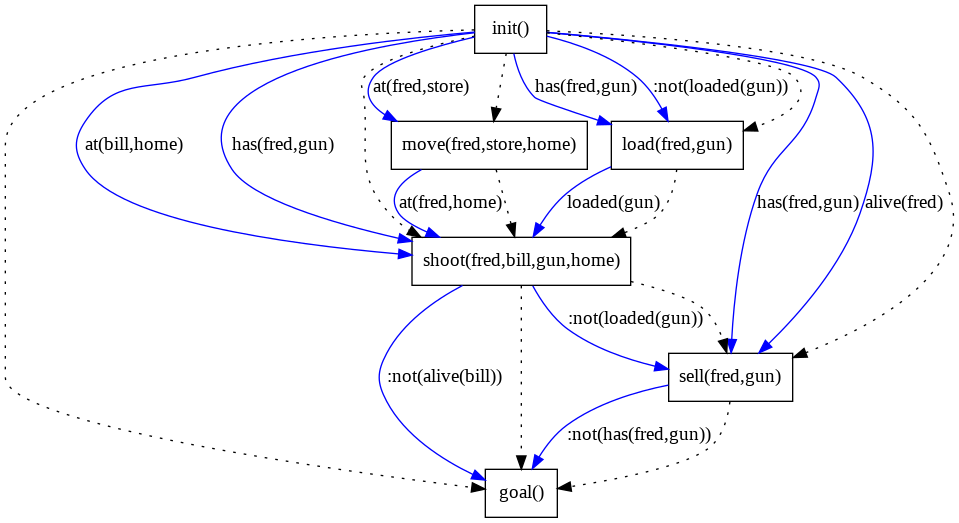

In [164]:
visualize(the_plan)

# Bank Robbery domain



In [135]:
### INIT

init = []

### GOAL

goal = []

### VARS


### OPERATORS
OPS = []

In [138]:
COUNTER = 0
the_plan = make_plan(init, goal, OPS)
if the_plan:
  print("SOLUTION----------------------------")
  the_plan.pretty_print()

# Your Domain

In [ ]:
### INIT

init = []

### GOAL

goal = []

### VARS


### OPERATORS
OPS = []

In [ ]:
COUNTER = 0
the_plan = make_plan(init, goal, OPS)
if the_plan:
  print("SOLUTION----------------------------")
  the_plan.pretty_print()